## Import Libraries and Define Variables

In [1]:
import os
import csv
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

/opt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Data Manipulation

In [2]:
train_df = pd.read_csv('H2full.csv', dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [3]:
from pandas import DataFrame  

df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
5,2015,27
6,2015,27
7,2015,27
8,2015,27
9,2015,27


## Concatenate dates and values

### Useful reference: https://datatofish.com/concatenate-values-python/

In [4]:
df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
79325    201735
79326    201735
79327    201735
79328    201735
79329    201735
Length: 79330, dtype: object


In [5]:
df2 = DataFrame(c, columns= ['IsCanceled']) 
df2

,IsCanceled
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,0.0
7,1.0
8,1.0
9,1.0


In [6]:
type(df1)

pandas.core.frame.DataFrame

In [7]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'IsCanceled']

In [8]:
df3
df3.sort_values(['FullDate','IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
6,201527,0.0
10,201527,0.0
11,201527,0.0
12,201527,0.0
13,201527,0.0
15,201527,0.0
17,201527,0.0
18,201527,0.0
22,201527,0.0


In [9]:
df4 = df3.groupby('FullDate').agg(sum)
df4
df4.sort_values(['FullDate'], ascending=True)

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


In [10]:
tseries=df4['IsCanceled']
tseries

FullDate
201527     97.0
201528    153.0
201529    228.0
201530    321.0
201531    159.0
          ...  
201731    253.0
201732    269.0
201733    341.0
201734    201.0
201735    129.0
Name: IsCanceled, Length: 115, dtype: float64

## Plot time series

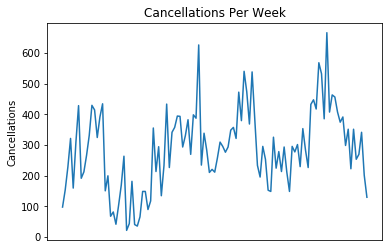

In [11]:
import matplotlib.pyplot as plt
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Cancellations')
plt.title("Cancellations Per Week")
plt.show()

In [12]:
df=pd.DataFrame(tseries)
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


In [13]:
df = df[:100]

In [14]:
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


## Form dataset matrix

In [15]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
201532,308.0
201533,428.0
201534,191.0
201535,212.0


## Normalize dataset with MinMaxScaler

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.11782946],
       [0.20465116],
       [0.32093023],
       [0.46511628],
       [0.21395349],
       [0.44496124],
       [0.63100775],
       [0.26356589],
       [0.29612403],
       [0.37984496],
       [0.48062016],
       [0.63255814],
       [0.60930233],
       [0.46976744],
       [0.57364341],
       [0.64031008],
       [0.2       ],
       [0.27596899],
       [0.07131783],
       [0.09302326],
       [0.03100775],
       [0.12713178],
       [0.22945736],
       [0.3751938 ],
       [0.        ],
       [0.03410853],
       [0.24806202],
       [0.02945736],
       [0.02170543],
       [0.06821705],
       [0.19689922],
       [0.19689922],
       [0.10542636],
       [0.14883721],
       [0.51782946],
       [0.29767442],
       [0.42325581],
       [0.1751938 ],
       [0.32868217],
       [0.63875969],
       [0.31782946],
       [0.49612403],
       [0.52093023],
       [0.57829457],
       [0.57674419],
       [0.42170543],
       [0.47906977],
       [0.559

## Create training and validation dataset with five previous values

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Training and Validation data partition
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

# Number of previous
previous = 5
X_train, Y_train = create_dataset(train, previous)
X_val, Y_val = create_dataset(val, previous)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [19]:
X_train

array([[0.11782946, 0.20465116, 0.32093023, 0.46511628, 0.21395349],
       [0.20465116, 0.32093023, 0.46511628, 0.21395349, 0.44496124],
       [0.32093023, 0.46511628, 0.21395349, 0.44496124, 0.63100775],
       [0.46511628, 0.21395349, 0.44496124, 0.63100775, 0.26356589],
       [0.21395349, 0.44496124, 0.63100775, 0.26356589, 0.29612403],
       [0.44496124, 0.63100775, 0.26356589, 0.29612403, 0.37984496],
       [0.63100775, 0.26356589, 0.29612403, 0.37984496, 0.48062016],
       [0.26356589, 0.29612403, 0.37984496, 0.48062016, 0.63255814],
       [0.29612403, 0.37984496, 0.48062016, 0.63255814, 0.60930233],
       [0.37984496, 0.48062016, 0.63255814, 0.60930233, 0.46976744],
       [0.48062016, 0.63255814, 0.60930233, 0.46976744, 0.57364341],
       [0.63255814, 0.60930233, 0.46976744, 0.57364341, 0.64031008],
       [0.60930233, 0.46976744, 0.57364341, 0.64031008, 0.2       ],
       [0.46976744, 0.57364341, 0.64031008, 0.2       , 0.27596899],
       [0.57364341, 0.64031008, 0.

In [20]:
Y_train

array([0.44496124, 0.63100775, 0.26356589, 0.29612403, 0.37984496,
       0.48062016, 0.63255814, 0.60930233, 0.46976744, 0.57364341,
       0.64031008, 0.2       , 0.27596899, 0.07131783, 0.09302326,
       0.03100775, 0.12713178, 0.22945736, 0.3751938 , 0.        ,
       0.03410853, 0.24806202, 0.02945736, 0.02170543, 0.06821705,
       0.19689922, 0.19689922, 0.10542636, 0.14883721, 0.51782946,
       0.29767442, 0.42325581, 0.1751938 , 0.32868217, 0.63875969,
       0.31782946, 0.49612403, 0.52093023, 0.57829457, 0.57674419,
       0.42170543, 0.47906977, 0.55968992, 0.38449612, 0.58449612,
       0.56744186, 0.9379845 , 0.33023256, 0.49147287, 0.40620155,
       0.29302326, 0.30852713, 0.29457364, 0.36589147, 0.44651163,
       0.4248062 , 0.39534884, 0.42170543, 0.50697674, 0.52093023,
       0.46511628, 0.69922481, 0.55503876, 0.80465116, 0.70077519,
       0.5379845 , 0.80155039, 0.5627907 , 0.32868217, 0.26976744,
       0.4248062 , 0.35968992, 0.20310078, 0.19689922])

## Reshape input to be [samples, time steps, features]

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

## Generate LSTM network

In [22]:
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

Train on 74 samples
Epoch 1/20
74/74 - 1s - loss: 0.1069
Epoch 2/20
74/74 - 0s - loss: 0.0461
Epoch 3/20
74/74 - 0s - loss: 0.0326
Epoch 4/20
74/74 - 0s - loss: 0.0308
Epoch 5/20
74/74 - 0s - loss: 0.0307
Epoch 6/20
74/74 - 0s - loss: 0.0300
Epoch 7/20
74/74 - 0s - loss: 0.0297
Epoch 8/20
74/74 - 0s - loss: 0.0298
Epoch 9/20
74/74 - 0s - loss: 0.0296
Epoch 10/20
74/74 - 0s - loss: 0.0292
Epoch 11/20
74/74 - 0s - loss: 0.0284
Epoch 12/20
74/74 - 0s - loss: 0.0281
Epoch 13/20
74/74 - 0s - loss: 0.0280
Epoch 14/20
74/74 - 0s - loss: 0.0280
Epoch 15/20
74/74 - 0s - loss: 0.0275
Epoch 16/20
74/74 - 0s - loss: 0.0271
Epoch 17/20
74/74 - 0s - loss: 0.0272
Epoch 18/20
74/74 - 0s - loss: 0.0268
Epoch 19/20
74/74 - 0s - loss: 0.0267
Epoch 20/20
74/74 - 0s - loss: 0.0266


## Generate predictions

In [23]:
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [24]:
trainpred

array([[0.33495316],
       [0.39868706],
       [0.44898915],
       [0.377619  ],
       [0.4364363 ],
       [0.42756933],
       [0.37861452],
       [0.4462902 ],
       [0.48713169],
       [0.5020385 ],
       [0.5343543 ],
       [0.52278507],
       [0.4392746 ],
       [0.45574808],
       [0.3560594 ],
       [0.24019948],
       [0.20526382],
       [0.17037578],
       [0.19981468],
       [0.25367066],
       [0.24435887],
       [0.24368024],
       [0.24631107],
       [0.15591979],
       [0.16976497],
       [0.18266866],
       [0.16649213],
       [0.19524455],
       [0.21389809],
       [0.23813832],
       [0.30625692],
       [0.30127633],
       [0.37526274],
       [0.39059818],
       [0.3582347 ],
       [0.420658  ],
       [0.36184397],
       [0.45222116],
       [0.48714265],
       [0.45322245],
       [0.5064837 ],
       [0.48928392],
       [0.49929163],
       [0.4916529 ],
       [0.44270325],
       [0.49289462],
       [0.4944155 ],
       [0.547

In [25]:
valpred

array([[0.3840812 ],
       [0.34926844],
       [0.3831051 ],
       [0.36013559],
       [0.38491136],
       [0.41566026],
       [0.4369042 ],
       [0.42591444],
       [0.40627974],
       [0.47813916],
       [0.47297657],
       [0.49480715],
       [0.5938013 ],
       [0.5814473 ]], dtype=float32)

## Convert predictions back to normal values

In [26]:
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [27]:
import math
from sklearn.metrics import mean_squared_error

## calculate RMSE

In [28]:
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 104.06 RMSE
Validation Score: 101.05 RMSE


## Train predictions

In [29]:
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

## Validation predictions

In [30]:
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(previous*2)+1:len(df)-1, :] = valpred

## Plot all predictions

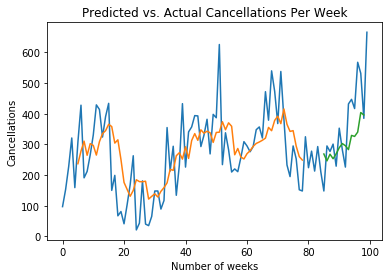

In [31]:
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(trainpredPlot)
valpred, =plt.plot(valpredPlot)
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.show()

In [32]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [33]:
Y_val

0     148.0
1     295.0
2     277.0
3     301.0
4     229.0
5     353.0
6     283.0
7     226.0
8     432.0
9     447.0
10    417.0
11    568.0
12    532.0
13    385.0
dtype: float64

In [34]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [35]:
predictions

0     268.732391
1     246.278137
2     268.102783
3     253.287460
4     269.267822
5     289.100861
6     302.803192
7     295.714813
8     283.050446
9     329.399750
10    326.069885
11    340.150604
12    404.001862
13    396.033508
dtype: float32

In [36]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [37]:
mda(Y_val, predictions)

0.8571428571428571

## Calculate mean squared error

### Useful reference: https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 101.054221


In [39]:
forecast_error = (predictions-Y_val)
forecast_error

0     120.732391
1     -48.721863
2      -8.897217
3     -47.712540
4      40.267822
5     -63.899139
6      19.803192
7      69.714813
8    -148.949554
9    -117.600250
10    -90.930115
11   -227.849396
12   -127.998138
13     11.033508
dtype: float64

In [40]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-44.35760607038225

In [41]:
X_train

array([[[0.11782946, 0.20465116, 0.32093023, 0.46511628, 0.21395349]],

       [[0.20465116, 0.32093023, 0.46511628, 0.21395349, 0.44496124]],

       [[0.32093023, 0.46511628, 0.21395349, 0.44496124, 0.63100775]],

       [[0.46511628, 0.21395349, 0.44496124, 0.63100775, 0.26356589]],

       [[0.21395349, 0.44496124, 0.63100775, 0.26356589, 0.29612403]],

       [[0.44496124, 0.63100775, 0.26356589, 0.29612403, 0.37984496]],

       [[0.63100775, 0.26356589, 0.29612403, 0.37984496, 0.48062016]],

       [[0.26356589, 0.29612403, 0.37984496, 0.48062016, 0.63255814]],

       [[0.29612403, 0.37984496, 0.48062016, 0.63255814, 0.60930233]],

       [[0.37984496, 0.48062016, 0.63255814, 0.60930233, 0.46976744]],

       [[0.48062016, 0.63255814, 0.60930233, 0.46976744, 0.57364341]],

       [[0.63255814, 0.60930233, 0.46976744, 0.57364341, 0.64031008]],

       [[0.60930233, 0.46976744, 0.57364341, 0.64031008, 0.2       ]],

       [[0.46976744, 0.57364341, 0.64031008, 0.2       , 0.27596

## Test (unseen) predictions: (t) and (t-5)

In [42]:
Xnew = np.array([[407,463,456,407,374],[463,456,407,374,391],[456,407,374,391,298],[407,374,391,298,351],[374,391,298,351,222],[391,298,351,222,351],[298,351,222,351,253],[351,222,351,253,269],[222,351,253,269,341],[351,253,269,341,201]])

In [43]:
Xnew

array([[407, 463, 456, 407, 374],
       [463, 456, 407, 374, 391],
       [456, 407, 374, 391, 298],
       [407, 374, 391, 298, 351],
       [374, 391, 298, 351, 222],
       [391, 298, 351, 222, 351],
       [298, 351, 222, 351, 253],
       [351, 222, 351, 253, 269],
       [222, 351, 253, 269, 341],
       [351, 253, 269, 341, 201]])

In [44]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

In [45]:
Xnew.shape

(10, 5)

In [46]:
ynew

array([[0.67532575],
       [0.65455824],
       [0.5388341 ],
       [0.57012326],
       [0.43916592],
       [0.4539636 ],
       [0.38548255],
       [0.31501505],
       [0.43381223],
       [0.2653158 ]], dtype=float32)

In [47]:
type(ynew)

numpy.ndarray

In [48]:
ynew.shape

(10, 1)

In [49]:
actual = np.array([[391,298,351,222,351,253,269,341,201,129]])

In [50]:
actual=actual.reshape(10,-1)
actual.shape

(10, 1)

In [51]:
actual

array([[391],
       [298],
       [351],
       [222],
       [351],
       [253],
       [269],
       [341],
       [201],
       [129]])

In [52]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [53]:
np.min(df)

0.0

In [54]:
ynew

array([0.67532575, 0.65455824, 0.5388341 , 0.57012326, 0.43916592,
       0.4539636 , 0.38548255, 0.31501505, 0.43381223, 0.2653158 ],
      dtype=float32)

In [55]:
maxcancel=np.max(tseries)

In [56]:
mincancel=np.min(tseries)

In [57]:
ynew = ynew * np.abs(maxcancel-mincancel) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [58]:
actualpd

0    391
1    298
2    351
3    222
4    351
5    253
6    269
7    341
8    201
9    129
dtype: int64

In [59]:
ynewpd

0    456.585114
1    443.190063
2    368.548004
3    388.729492
4    304.262024
5    313.806519
6    269.636230
7    224.184708
8    300.808899
9    192.128693
dtype: float32

In [60]:
mda(actualpd, ynewpd)

0.8

In [61]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 93.254144


In [62]:
forecast_error = (ynewpd-actualpd)
forecast_error

0     65.585114
1    145.190063
2     17.548004
3    166.729492
4    -46.737976
5     60.806519
6      0.636230
7   -116.815292
8     99.808899
9     63.128693
dtype: float64

In [63]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

45.587974548339844

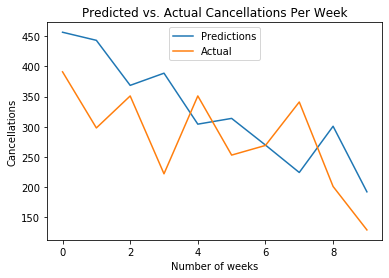

In [64]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.legend(loc = 'upper center')
plt.show()